This is a _working_ notebook. See the `ccdControlIntro` notebook for a more narrative how-to. In this notebook, most cells have acquisition, processing, and plotting.

In [1]:
import fpga as fpgaMod
import fee as feeMod
import time
import clocks

import fpga.ccdFuncs as ccdFuncs
import fpga.nbFuncs as nbFuncs

import numpy as np
import scipy
import scipy.optimize as opt

# Can be useful to turn on, but remember that if you do so the entire kernel
# will stop at a prompt in a cell which hits a breakpoint or uncaiught error.
%pdb off

import matplotlib.pyplot as plt

%matplotlib inline

Automatic pdb calling has been turned OFF


In [2]:
# Initialize everything to some sane state.
reload(feeMod)
fee = feeMod.FeeControl(logLevel=20)
fee.powerUp()
time.sleep(1)

connected to FEE, revision PFS BEE Rev-, copyright JHU
SUCCESS
SUCCESS
SUCCESS


In [21]:
for v in ('3V3M', '3V3', '5VP', '5VN', '5VPpa', '5VNpa', '12VP', '12VN', '24VN', '54VP'):
    print("%s = %s" % (v, fee.raw('gv,%s' % (v))))

3V3M = 3.28
3V3 = 3.26
5VP = 4.95
5VN = -4.93
5VPpa = 4.95
5VNpa = -4.86
12VP = 11.57
12VN = -11.67
24VN = -23.02
54VP = 49.15


In [4]:
reload(fpgaMod)
reload(fpgaMod.ccd)
reload(fpgaMod)

ccd = fpgaMod.CCD()
ccd.pciReset()
print "FPGA version: 0x%08x" % (ccd.peekWord(0))

FPGA version: 0xbeef0070


In [5]:
allAmps = np.arange(8)
goodAmps = allAmps
badAmps = []

startStep = [0.01]*8
ncols=500

import clocks_001
import clocks_002
import clocks
reload(clocks_001)
reload(clocks_002)
reload(clocks)

pfsClocks = clocks_001.standardClocks
ticks, opcodes = clocks.genRowClocks(ncols, pfsClocks) 
print len(ticks), ticks.sum()

5009 180172


offsets, levels = gainCurve(ccd, f, stepSize=0.03999)
print offsets
print levels

plotGains(offsets, levels)

In [6]:
# Run this to take the current N- offsets, and apply half to N- and half to N+ (opposite sign)
#fee.setLevels(range(8), offs/2)
#fee.setLevels(range(8), -offs/2, leg='p')

In [7]:
%pdb off
reload(nbFuncs)

doTune = False
if doTune:
    offs, devs, gains = nbFuncs.tuneLevels(ccd, fee, levels=1000, adjOffset=5, 
                                           statCols=np.arange(50,ncols), 
                                           maxLoops=10, nrows=200, startStep=startStep, 
                                           sigTol=3, 
                                           clocksFunc=pfsClocks, legs='n')

    defOffsets = offs
else:
    defOffsets = np.array([ 0.01719095,  0.01710775,  0.01768051,  0.01705352,  0.01732199,
                        0.01715419,  0.01763278,  0.01804331])
    offs = defOffsets
    fee.zeroLevels()
    fee.setLevels(range(8), defOffsets)

Automatic pdb calling has been turned OFF


Next cell does a short readout with mean & stddev stats for a few amps, the plots a row from those amps and the FFT for one amp. Fiddle with the various variables and arguments and repeat...

# row  means   stddevs
0299 29179808 327979   1005.0    995.1   1005.6    995.9   1005.1    994.8   1004.9    994.6  0.74  0.74  0.75  0.74  0.76  0.75  0.73  0.75 OK
file: /data/pfs/2015-03-18/PFSA-00000454.fits


readT=2.34 writeT=0.15


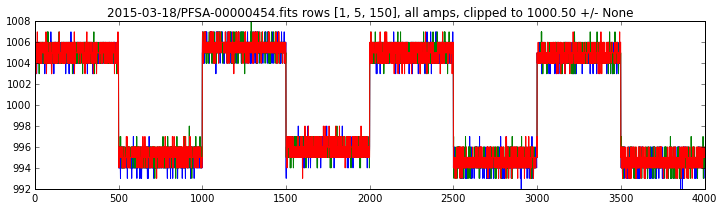

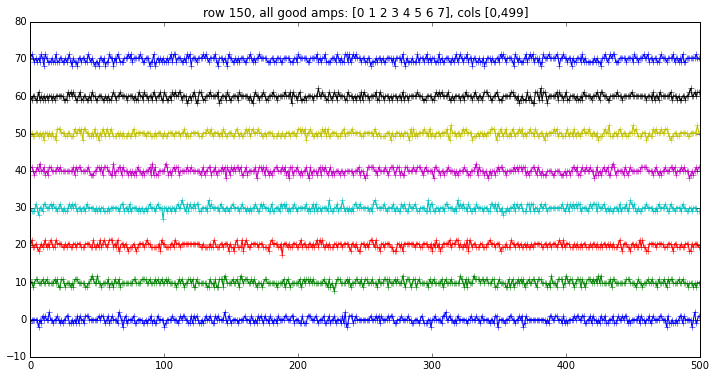

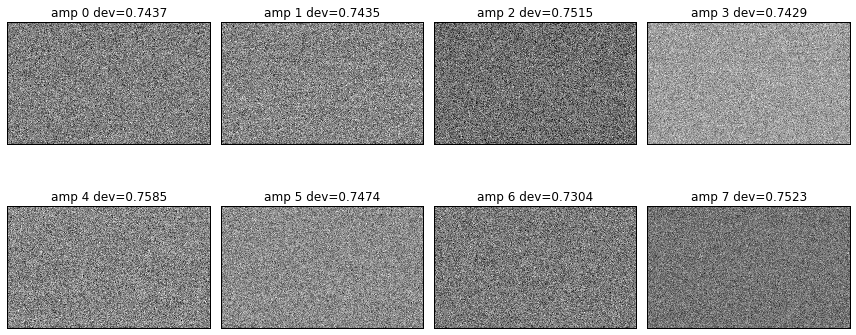

In [32]:
reload(ccdFuncs)
reload(nbFuncs)
fftAmps = []
nrows = 300                # How many rows to read out.
ncols = 500
pcols = np.arange(ncols)        # Which cols to plot
prow = (nrows+1)/2
prows = [1, 5, prow]      # which row to plot

figWidth = 12

argDict = dict(everyNRows=nrows-1, ampList=goodAmps, cols=pcols, ccd=ccd)

print "# row  means   stddevs"
im, files = ccd.readImage(nrows=nrows, ncols=ncols, 
                       rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                       clockFunc=pfsClocks)

path = files[0]
imName = '/'.join(path.split('/')[-2:])
print "file: %s" % (path)

#focusAmp = 0             # Which amp to focus on
#focusMask = ccd.ampidx(focusAmp, im)[pcols]

medpix = np.median(im[prows])

pixRange = None
f1 = plt.figure(figsize=(figWidth,figWidth/4))
for prow in prows:
    plt.plot(im[prow], scaley=pixRange is None)
    if pixRange is not None:
        plt.axis([None, None, medpix-pixRange, medpix+pixRnge])
plt.title('%s rows %s, all amps, clipped to %0.2f +/- %s' % (imName, prows, medpix, pixRange))
plt.show()

# Plot all the "good" amps
f2 = plt.figure(figsize=(figWidth,figWidth/2))
prow = prows[-1]
nbFuncs.plotAmps(im, amps=goodAmps, row=prow, cols=pcols, plotOffset=10, fig=f2)
plt.title('row %d, all good amps: %s, cols [%d,%d]' % (prow, goodAmps, 
                                                       pcols[0],pcols[-1]))

# plot the bad amps individually
for a in badAmps:
    nbFuncs.plotAmps(im, amps=[a], row=prow, cols=pcols, plotOffset=20)
    plt.title('row %d, bad amp %d' % (prow, a))


if len(fftAmps) > 0:    
    fftFig = plt.figure(figsize=(figWidth, figWidth/4))
    for a in fftAmps:
        fftMask = ccd.ampidx(a, im)[pcols]
        ampSeg = im[prow,fftMask]
        freqs, fft, peak_ii = ccdFuncs.plotTopPeriods(ampSeg, topN=3)

fig = plt.figure('amp_images', figsize=(figWidth, figWidth/2))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
r = 2
c = 4
for a in goodAmps:
    ampIm = im[:,ccd.ampidx(a, im)[pcols]]
    p = fig.add_subplot(r, c, a+1)
    p.xaxis.set_visible(False)
    p.yaxis.set_visible(False)

    pp = p.imshow(ampIm-ampIm.mean())
    plt.title('amp %d dev=%0.4f' % (a, ampIm.std()))
    
#fig.colorbar(pp)
plt.tight_layout()

In [23]:
offs

array([ 0.01719095,  0.01710775,  0.01768051,  0.01705352,  0.01732199,
        0.01715419,  0.01763278,  0.01804331])